In [74]:

import pandas as pd

df = pd.read_csv("../data/anime.csv")

In [77]:
#----GENERAL----
import numpy as np

df['genre_count'] = df['genre'].str.count(',') + 1

df['log_members'] = np.log1p(df['members'])
df.head()




,anime_id,name,genre,type,episodes,rating,members,genre_count,log_members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,4.0,12.209223
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,7.0,13.584418
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,7.0,11.646258
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,2.0,13.420352
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,7.0,11.926802


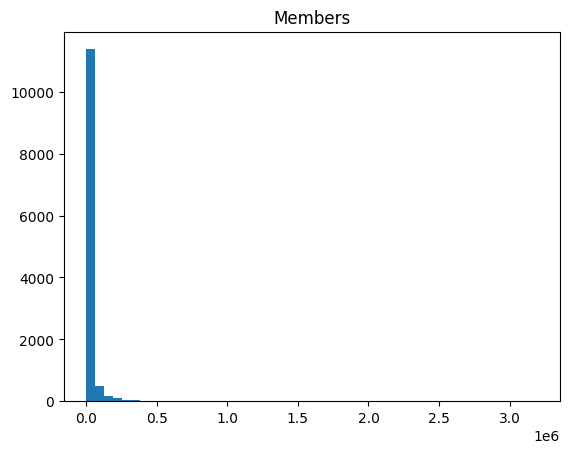

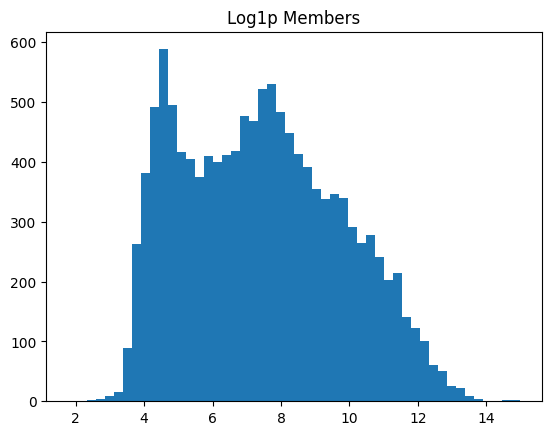

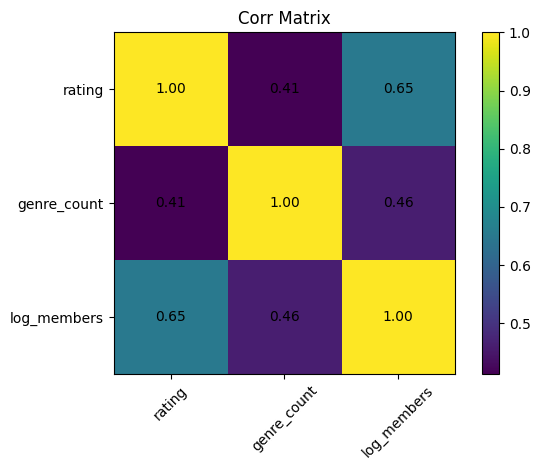

In [76]:
#---EDA PLOTS---
import matplotlib.pyplot as plt

plt.figure(); plt.hist(df['members'], bins=50); plt.title('Members'); plt.show()
plt.figure(); plt.hist(df['log_members'], bins=50); plt.title('Log1p Members'); plt.show()


corr = df[['rating','genre_count','log_members']].corr()
plt.figure(); plt.imshow(corr, interpolation='nearest'); plt.colorbar(); 
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j,i,f"{corr.iloc[i,j]:.2f}",ha='center',va='center')
plt.title('Corr Matrix'); plt.tight_layout(); plt.show()


In [ ]:
# ---REGRESSION COMPARISON---
import numpy as np
import pandas as pd

from sklearn.preprocessing    import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model     import LinearRegression, Ridge, Lasso
from sklearn.ensemble         import RandomForestRegressor
from sklearn.metrics          import mean_squared_error, mean_absolute_error, r2_score

df = df.dropna(subset=['genre', 'rating', 'members']).reset_index(drop=True)

df['genre_count'] = df['genre'].str.count(',') + 1
df['log_members']  = np.log1p(df['members'])

genre_lists = (
    df['genre']
      .astype(str)
      .str.split(',')
      .apply(lambda L: [g.strip() for g in L if g.strip()])
)
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(genre_lists),
    columns=mlb.classes_,
    index=df.index
)

X = pd.concat([df[['genre_count', 'log_members']], genre_dummies], axis=1)
y = df['rating']

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = [
    ("LinearReg",   LinearRegression()),
    ("Ridge α=1",   Ridge(alpha=1.0)),
    ("Lasso α=0.1", Lasso(alpha=0.1, max_iter=10_000)),
    ("RFReg",       RandomForestRegressor(n_estimators=100, random_state=42))
]

results = []
for name, model in models:
    # train
    model.fit(X_train, y_train)
    # predict
    y_pred = model.predict(X_test)
    # collect metrics
    results.append({
        "Model":         name,
        "MSE":           mean_squared_error(y_test, y_pred),
        "MAE":           mean_absolute_error(y_test, y_pred),
        "R²":            r2_score(y_test, y_pred),
        "CV R² (5-fold)": np.mean(cross_val_score(model, X_train, y_train,
                                                  cv=5, scoring="r2"))
    })

metrics_df = pd.DataFrame(results).set_index("Model")
print(metrics_df)



                  MSE       MAE        R²  CV R² (5-fold)
Model                                                    
LinearReg    0.518426  0.535809  0.502605        0.511380
Ridge α=1    0.518332  0.535736  0.502695        0.511420
Lasso α=0.1  0.583467  0.574525  0.440203        0.433010
RFReg        0.559656  0.534712  0.463048        0.487575


XGBoost Performance:
  MSE: 0.484
  MAE: 0.506
   R²: 0.537


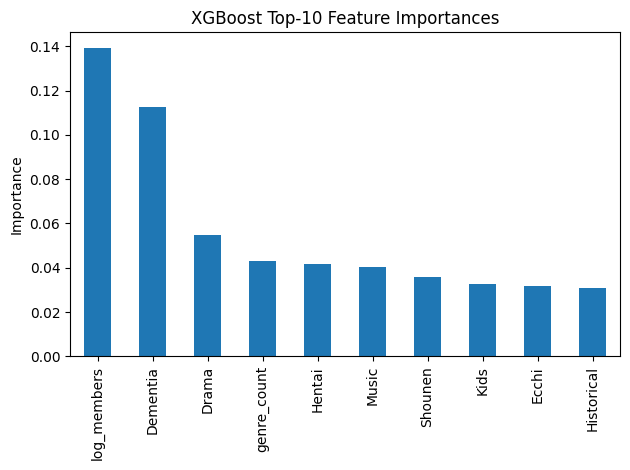

In [79]:
#---XGBOOST REGRESSOR ---
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)


xgb.fit(X_train, y_train)

# Predict & evaluate
y_pred_xgb = xgb.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("XGBoost Performance:")
print(f"  MSE: {mean_squared_error(y_test, y_pred_xgb):.3f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_xgb):.3f}")
print(f"   R²: {r2_score(y_test, y_pred_xgb):.3f}")

import matplotlib.pyplot as plt
import pandas as pd

fi = pd.Series(xgb.feature_importances_, index=X.columns)
top10 = fi.sort_values(ascending=False).head(10)

plt.figure()
top10.plot(kind='bar')
plt.title("XGBoost Top-10 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [73]:
# show rows where genre isn't a string
bad = df[~df['genre'].apply(lambda x: isinstance(x, str))]

print(bad[['anime_id','name','genre']])


       anime_id                                               name genre
2844      33242          IS: Infinite Stratos 2 - Infinite Wedding   NaN
6040      29765                                  Metropolis (2009)   NaN
6646      32695                                       Match Shoujo   NaN
7018      33187                                   Katsudou Shashin   NaN
7198      30862                               Yubi wo Nusunda Onna   NaN
7335      28987                                           Kamakura   NaN
7349      19219                                        Modern No.2   NaN
7426      29629                                       Coffee Break   NaN
7498      28653                                               Maze   NaN
7591      31834                                         Mormorando   NaN
7645      31507                              Ari Ningen Monogatari   NaN
7685      31760                              Tsuru Shitae Waka Kan   NaN
7708      28587                                    